## Protein embeddings and how they work

This notebook uses ESM pytorch implementation as example to convert a protein sequence to an embedding representation with a pre-trained (protein) language model.

In this case we can use the basic environment (no GPU required)

### ESM basic usage

In [1]:
seq = "KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL"
print(len(seq))

129


Load pre-trained model. Check https://github.com/facebookresearch/esm#available-models.



In [2]:
import torch as tr

# pretrained model parameters
MAX_LEN = 1022
LAST_LAYER = 30
MODEL_NAME = "esm2_t30_150M_UR50D"
MODEL_OWNER = "facebookresearch/esm:main"

model, alphabet = tr.hub.load(MODEL_OWNER,
                              MODEL_NAME)
model.eval()
batch_converter = alphabet.get_batch_converter()

Downloading: "https://github.com/facebookresearch/esm/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t30_150M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t30_150M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D-contact-regression.pt


In [3]:
# I need to pass a list with tupples (id, sequence)
x = [(0, seq)]

# and convert sequence to tokens IDs
_, _, tokens = batch_converter(x)
tokens

tensor([[ 0, 15,  7, 18,  6, 10, 23,  9,  4,  5,  5,  5, 20, 15, 10, 21,  6,  4,
         13, 17, 19, 10,  6, 19,  8,  4,  6, 17, 22,  7, 23,  5,  5, 15, 18,  9,
          8, 17, 18, 17, 11, 16,  5, 11, 17, 10, 17, 11, 13,  6,  8, 11, 13, 19,
          6, 12,  4, 16, 12, 17,  8, 10, 22, 22, 23, 17, 13,  6, 10, 11, 14,  6,
          8, 10, 17,  4, 23, 17, 12, 14, 23,  8,  5,  4,  4,  8,  8, 13, 12, 11,
          5,  8,  7, 17, 23,  5, 15, 15, 12,  7,  8, 13,  6, 17,  6, 20, 17,  5,
         22,  7,  5, 22, 10, 17, 10, 23, 15,  6, 11, 13,  7, 16,  5, 22, 12, 10,
          6, 23, 10,  4,  2]])

In [4]:
# Dictionary of all possible tokens
print(alphabet.all_toks)

['<cls>', '<pad>', '<eos>', '<unk>', 'L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C', 'X', 'B', 'U', 'Z', 'O', '.', '-', '<null_1>', '<mask>']


In [5]:
out = model(tokens, repr_layers=[LAST_LAYER])
out

{'logits': tensor([[[ 19.8905,  -5.0456,   2.6023,  ..., -15.5680, -16.8192,  -4.9434],
          [ -7.3927, -14.3215,  -9.2399,  ..., -15.5324, -15.8458, -14.2999],
          [-11.1197, -18.0868, -13.6868,  ..., -14.8367, -15.7511, -18.1431],
          ...,
          [-10.7823, -18.5397, -11.4996,  ..., -15.8849, -15.8424, -18.5891],
          [-11.9178, -19.0137, -12.8534,  ..., -15.8699, -16.3108, -19.0514],
          [ -1.0203,  -6.4456,  20.5182,  ..., -15.1321, -15.2638,  -6.3740]]],
        grad_fn=<AddBackward0>),
 'representations': {30: tensor([[[-0.0933, -0.0360,  0.0030,  ..., -0.0159, -0.0502,  0.0745],
           [-0.1261, -0.1058,  0.1309,  ..., -0.3885, -0.4442, -0.2231],
           [-0.2528, -0.1855, -0.0433,  ..., -0.5451,  0.0672,  0.1594],
           ...,
           [-0.0265,  0.0229, -0.1767,  ..., -0.1606, -0.0713, -0.0971],
           [-0.2534,  0.2039, -0.0724,  ..., -0.1833, -0.4043,  0.0516],
           [-0.0072, -0.1050, -0.1800,  ...,  0.0527,  0.0136,  0.04

#### Representations
These are the learnt embeddings for each position in the sequence. Notice that even if the residue is the same aminoacid, representations may differ as the model learn from the whole sequence context

In [6]:
emb = out["representations"][30].detach()
emb.shape # [N x L x E]

torch.Size([1, 131, 640])

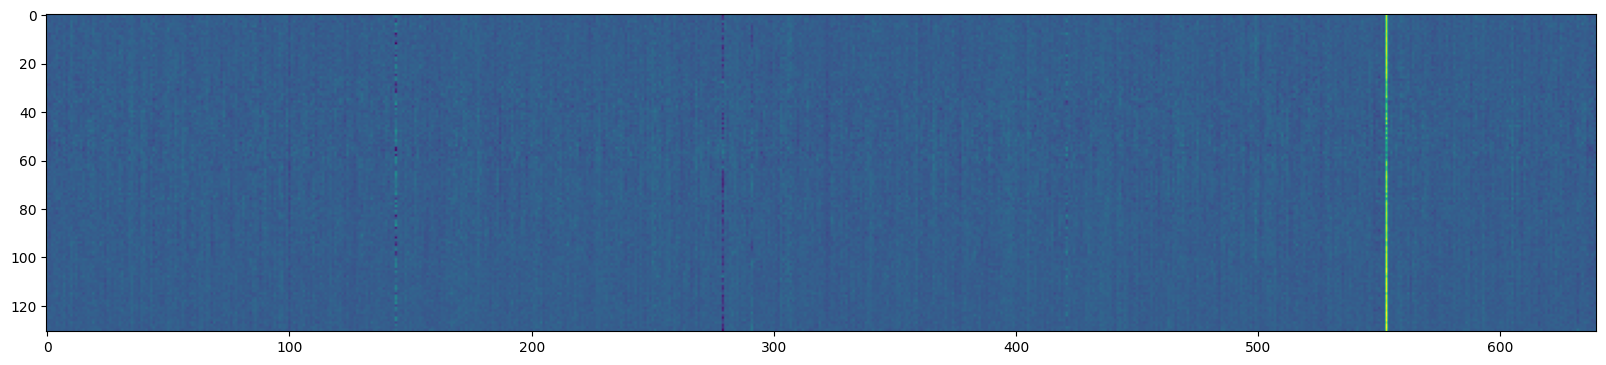

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.imshow(emb.squeeze())

In [8]:
# we can get the representation of a particular residue
i = 23
print(i, seq[i], emb[0, i, :].shape)

23 S torch.Size([640])


In [9]:
# or even get the average representation of the sequence
print(emb.mean(dim=1).shape) # this vector conttains information of the whole sequence

torch.Size([1, 640])


#### "Logits"
These are the predicted token scores for each position. This is, for each sequence position the model make a prediction of "probability distribution" of all possible tokens.

This can be used to understand if the sequence is correctly modeled (this can be interpreted as the model perplexity), or which tokens may be interchangeable.

In [10]:
out["logits"].shape

torch.Size([1, 131, 33])

Notice the high probability of token 0 at the beggining (<cls>) and token 2 (<eos>) at the end

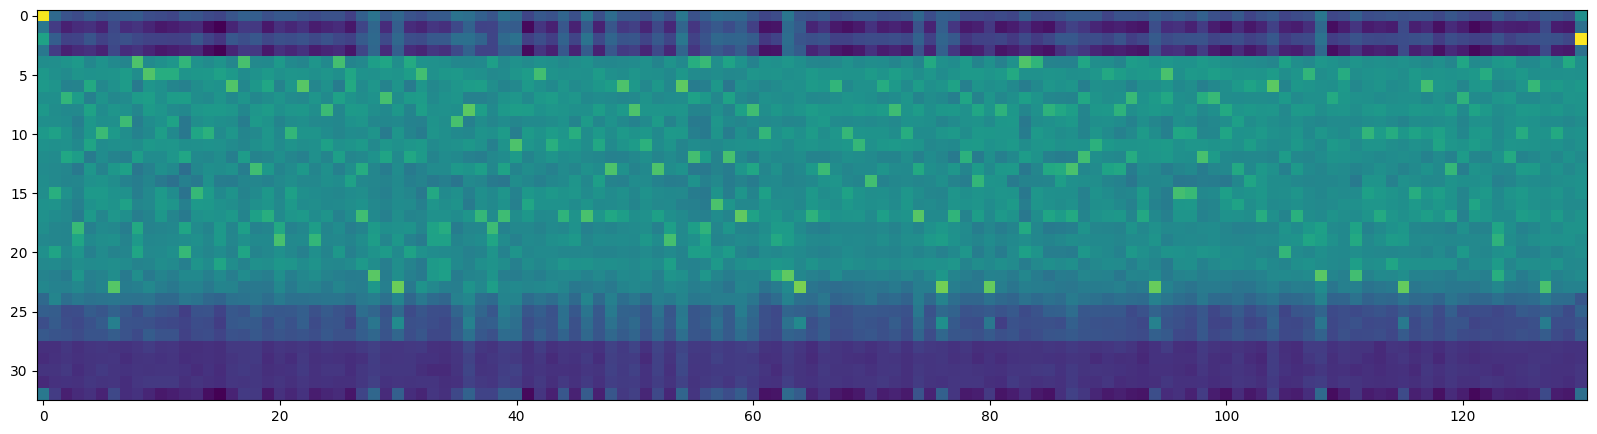

In [11]:
plt.figure(figsize=(20, 10))
plt.imshow(out["logits"][0].detach().T)

We can measure the model perplexity for each position

In [19]:
logits = out["logits"][0].detach().unsqueeze(0)

In [20]:
logits.shape

torch.Size([1, 131, 33])

In [14]:
tokens

tensor([[ 0, 15,  7, 18,  6, 10, 23,  9,  4,  5,  5,  5, 20, 15, 10, 21,  6,  4,
         13, 17, 19, 10,  6, 19,  8,  4,  6, 17, 22,  7, 23,  5,  5, 15, 18,  9,
          8, 17, 18, 17, 11, 16,  5, 11, 17, 10, 17, 11, 13,  6,  8, 11, 13, 19,
          6, 12,  4, 16, 12, 17,  8, 10, 22, 22, 23, 17, 13,  6, 10, 11, 14,  6,
          8, 10, 17,  4, 23, 17, 12, 14, 23,  8,  5,  4,  4,  8,  8, 13, 12, 11,
          5,  8,  7, 17, 23,  5, 15, 15, 12,  7,  8, 13,  6, 17,  6, 20, 17,  5,
         22,  7,  5, 22, 10, 17, 10, 23, 15,  6, 11, 13,  7, 16,  5, 22, 12, 10,
          6, 23, 10,  4,  2]])

In [22]:
def logits_to_logprobs(
    logits: tr.Tensor,
    input_ids: tr.Tensor,
    trim_bos: bool = True,
) -> tr.Tensor:
    """
    Takes in a tensor of logits of dimension (batch, length, vocab).
    Computes the log-likelihoods using a softmax along the vocab dimension.
    Uses the `input_ids` to index into the log-likelihoods and returns the likelihood
    of the provided sequence at each position with dimension (batch, length).
    """
    softmax_logprobs = tr.log_softmax(logits, dim=-1)
    if trim_bos:
        softmax_logprobs = softmax_logprobs[:, :-1] # Remove last prediction.
        input_ids = input_ids[:, 1:] # Trim BOS added by tokenizer.
    assert(softmax_logprobs.shape[1] == input_ids.shape[1])

    logprobs = tr.gather(
        softmax_logprobs,       # Gather likelihoods...
        2,                      # along the vocab dimension...
        input_ids.unsqueeze(-1) # using the token ids to index.
    ).squeeze(-1)

    return logprobs

likelihood1 = logits_to_logprobs(logits, tokens)

Now what happens if we make a weird sequence mutation

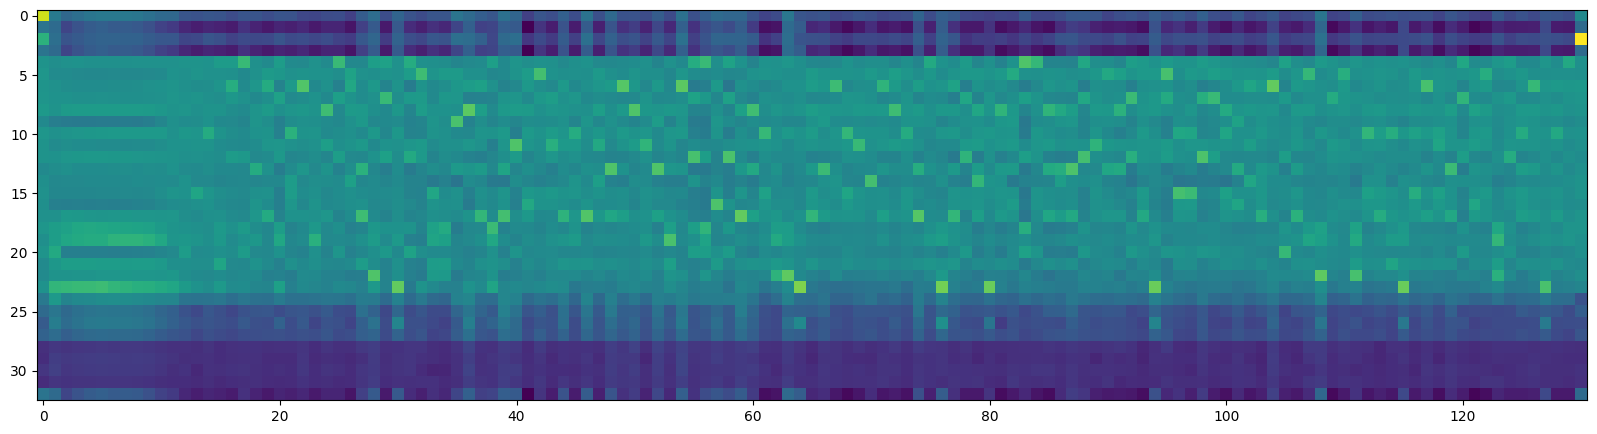

In [25]:
seq = "CCCCCCCCCCCMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL"
x = [(0, seq)]
_, _, tokens = batch_converter(x)
out = model(tokens, repr_layers=[LAST_LAYER])
plt.figure(figsize=(20, 10))
plt.imshow(out["logits"][0].detach().T)

likelihood2 = logits_to_logprobs(out["logits"].detach(), tokens)


In [27]:
likelihood1.shape

torch.Size([1, 130])

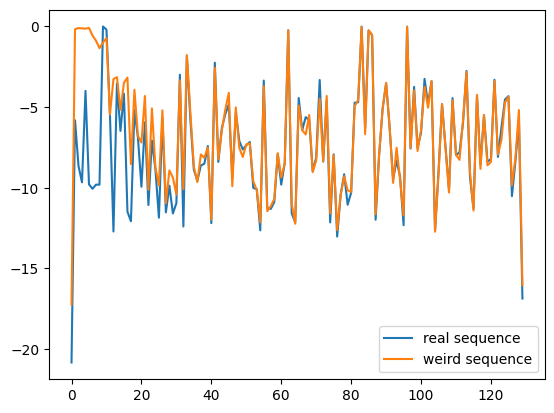

In [30]:
plt.plot(likelihood1.squeeze(), label="real sequence")
plt.plot(likelihood2.squeeze(), label="weird sequence")
plt.legend();

### Protein domains representations
Using a small dataset from Pfam we can evaluate how sequences are represented in the embedding space

In [31]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.5 MB/s eta 0:00:00


In [32]:
# load all embeddings
import os
import pickle
import numpy as np
import pandas as pd

data_path = "https://raw.githubusercontent.com/lbugnon/foundation_models_bioinfo/refs/heads/main/data/"

df = pd.read_csv(f"{data_path}pfam_some_sequences.csv", index_col="sequence_name")
df.head()

,sequence,part,family
sequence_name,,,
A0A0N8W5W1_9SPHI-51-293,TNVANNSWEANDAIGVFMKSGTGLSNVLAANKNYNTTGDGNFKPTT...,train,PF13149
Q9CED5_LACLA-179-318,ADRVRILAGKNNLYASIILAQAILESGSGQSNMSQQYFNIFNITGA...,train,PF01832
O88074_STRCO-32-367,HLGPNWYACVMGTAIVGTAGAALPGHVAGLRAACTAVWALSLVLLV...,train,PF03595
E3D0F4_9BACT-6-484,DLTERPWILCRLRDGSTVSLGLLDLFLRAPEIEGIVGGDPLEEGAL...,train,PF09481
C5ASA7_METEA-77-324,LILYVGGNYFFAMAPLVAAFEARHPDLAGRIYYETIPPGLLVRQMR...,train,PF13531


In [33]:
# download pre-computed embeddings
!gdown 1JCz0_xc9Wn8vIORIyNoF_5WAPyTplz3E # esm2_t33_650M_UR50D
embeddings = pickle.load(open("esm2_t33_650M_UR50D.pk", "rb"))

# convert dict to array
embeddings = np.array([embeddings[i] for i in df.index])
embeddings.shape #[N x E]

Downloading...
From (original): https://drive.google.com/uc?id=1JCz0_xc9Wn8vIORIyNoF_5WAPyTplz3E
From (redirected): https://drive.google.com/uc?id=1JCz0_xc9Wn8vIORIyNoF_5WAPyTplz3E&confirm=t&uuid=db4ae2be-1aec-4133-bfcf-15217dcd282c
To: /content/esm2_t33_650M_UR50D.pk
100% 210M/210M [00:03<00:00, 60.5MB/s]


(80211, 1280)

Project embedding space (1280) to 2D for visual representation (take ~6 minutes)

In [34]:
import umap
umap_model = umap.UMAP(n_components=2)
emb2D = umap_model.fit_transform(embeddings)

Now we take 9 random families from the dataset and colorize them in the projected data. With this dimensional reduction method two similar sequences should be placed close to each other.

['PF04230' 'PF01636' 'PF01850' 'PF09594' 'PF01014' 'PF13579' 'PF13279'
 'PF01145' 'PF14092']


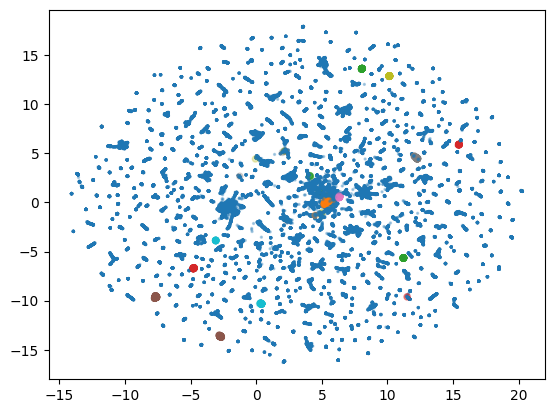

In [36]:
import matplotlib.pyplot as plt

families = df.family.values
some_families = np.random.choice(np.unique(families), 9, replace=False)
print(some_families)

colors = np.zeros(emb2D.shape[0])
sizes = 2*np.ones(emb2D.shape[0])
for k, fam in enumerate(some_families):
    colors[np.array(families)==fam] = k
    sizes[np.array(families)==fam] = 20

plt.scatter(emb2D[:, 0], emb2D[:, 1], alpha=.3, c=colors, s=sizes, cmap="tab10");

We can repeat the analysis for the protein clans

In [37]:
#plot clans
pf2clans = pd.read_csv(f"{data_path}pfam_some_families.csv", index_col="PF")
pf2clans.head()

,CLAN
PF,
PF00003,CL0192
PF00034,CL0318
PF00061,CL0116
PF00091,CL0566
PF00092,CL0128


In [38]:
pf2clans.loc[some_families]

,CLAN
PF,
PF04230,CL0113
PF01636,CL0016
PF01850,CL0280
PF09594,CL0111
PF01014,CL0334
PF13579,CL0113
PF13279,CL0050
PF01145,CL0433
PF14092,NaN


In [39]:
clans = np.array([pf2clans[pf2clans.index==fam].CLAN.item() for fam in families])
some_clans = (set([str(v.item()) for v in pf2clans.loc[some_families].values if str(v.item())!="nan"]))

some_clans

{'CL0016', 'CL0050', 'CL0111', 'CL0113', 'CL0280', 'CL0334', 'CL0433'}

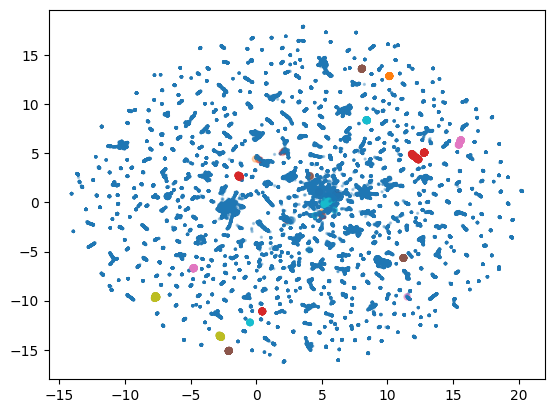

In [40]:
colors = np.zeros(emb2D.shape[0])
sizes = 2*np.ones(emb2D.shape[0])
for k, clan in enumerate(some_clans):
    colors[np.array(clans)==clan] = k
    sizes[np.array(clans)==clan] = 20

plt.scatter(emb2D[:, 0], emb2D[:, 1], alpha=.3, c=colors, s=sizes, cmap="tab10");

### Sequence similarity in the embedding space

In [41]:
!gdown 10E9WPNogQlUhVRiX44trdArdUNiOues7
!tar -xvf fam_dist.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=10E9WPNogQlUhVRiX44trdArdUNiOues7
From (redirected): https://drive.google.com/uc?id=10E9WPNogQlUhVRiX44trdArdUNiOues7&confirm=t&uuid=c304b87a-7712-4dd7-a7b0-8a9f259401f8
To: /content/fam_dist.tar.gz
100% 422M/422M [00:08<00:00, 49.1MB/s]
fam_dist/
fam_dist/PF12705.txt
fam_dist/PF05235.txt
fam_dist/PF00882.txt
fam_dist/PF10722.txt
fam_dist/PF00590.txt
fam_dist/PF01048.txt
fam_dist/PF00482.txt
fam_dist/PF03435.txt
fam_dist/PF13868.txt
fam_dist/PF08592.txt
fam_dist/PF14009.txt
fam_dist/PF03063.txt
fam_dist/PF03313.txt
fam_dist/PF13279.txt
fam_dist/PF06834.txt
fam_dist/PF13886.txt
fam_dist/PF12215.txt
fam_dist/PF13259.txt
fam_dist/PF11709.txt
fam_dist/PF01547.txt
fam_dist/PF10416.txt
fam_dist/PF13584.txt
fam_dist/PF13579.txt
fam_dist/PF13858.txt
fam_dist/PF10604.txt
fam_dist/PF09375.txt
fam_dist/PF11838.txt
fam_dist/PF01124.txt
fam_dist/PF03372.txt
fam_dist/PF03168.txt
fam_dist/PF04286.txt
fam_dist/PF01105.txt
fam_dist/PF18739.

Blast output format 6:

1.  qseqid      query or source (gene) sequence id
2.  sseqid      subject or target (reference genome) sequence id
3.  pident      percentage of identical positions
4.  length      alignment length (sequence overlap)
5.  mismatch    number of mismatches
6.  gapopen     number of gap openings
7.  qstart      start of alignment in query
8.  qend        end of alignment in query
9.  sstart      start of alignment in subject
10.  send        end of alignment in subject
11.  evalue      expect value
12.  bitscore    bit score


In [42]:
fam = "PF13149"
!head fam_dist/{fam}.txt

A0A0N8W5W1_9SPHI/51-293	A0A0N8W5W1_9SPHI/51-293	100.000	243	0	0	1	243	1	243	1.05e-179	486
A0A0N8W5W1_9SPHI/51-293	A0A081PM50_9SPHI/51-293	63.786	243	88	0	1	243	1	243	1.79e-118	331
A0A0N8W5W1_9SPHI/51-293	A0A0Q1ACU2_9SPHI/49-292	57.787	244	102	1	1	243	1	244	1.83e-101	288
A0A0N8W5W1_9SPHI/51-293	D7VSB5_9SPHI/48-287	49.794	243	119	3	1	243	1	240	7.13e-77	225
A0A0N8W5W1_9SPHI/51-293	A0A077EJW3_9FLAO/52-291	48.971	243	121	3	1	243	1	240	2.49e-75	221
A0A0N8W5W1_9SPHI/51-293	U2J3I7_9SPHI/48-287	48.163	245	120	5	1	243	1	240	1.54e-73	217
A0A0N8W5W1_9SPHI/51-293	R5US92_9BACT/46-291	44.800	250	127	8	1	243	1	246	6.48e-68	203
A0A0N8W5W1_9SPHI/51-293	R6T338_9BACE/47-287	40.816	245	139	5	1	243	1	241	1.02e-57	176
A0A0N8W5W1_9SPHI/51-293	R7A861_9BACE/43-287	35.887	248	147	8	3	243	3	245	2.26e-42	137
A0A0N8W5W1_9SPHI/51-293	A0A0A2FJ36_9PORP/50-293	38.672	256	132	12	1	243	1	244	1.18e-41	135


In [45]:
seq1 = "A0A0N8W5W1_9SPHI-51-293"
seq2 = "A0A081PM50_9SPHI-51-293"
seq3 = "A0A0A2FJ36_9PORP-50-293"

embeddings = pickle.load(open("esm2_t33_650M_UR50D.pk", "rb"))

In [46]:
print((embeddings[seq1]-embeddings[seq1]).mean())
print((embeddings[seq1]-embeddings[seq2]).mean())
print((embeddings[seq1]-embeddings[seq3]).mean())

0.0
-5.8e-06
0.0001446


(None,)

In [49]:
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-6)
cos(tr.tensor(embeddings[seq1]).unsqueeze(0), tr.tensor(embeddings[seq1]).unsqueeze(0))

tensor([0.9995], dtype=torch.float16)

In [51]:
cos(tr.tensor(embeddings[seq1]).unsqueeze(0), tr.tensor(embeddings[seq2]).unsqueeze(0))

tensor([0.9971], dtype=torch.float16)

In [50]:
cos(tr.tensor(embeddings[seq1]).unsqueeze(0), tr.tensor(embeddings[seq3]).unsqueeze(0))

tensor([0.9922], dtype=torch.float16)